# Do intracellular biomarkers work with extracellular samples?
```
5/23/23
Andrew E. Davidson
aedavids@ucsc.edu
```
ref:  
extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/bestSignatureGenesBaseMeanBugFixPOC.ipynb
    
<span style="color:red">TODO</span>

Preliminary evidence that intracellular biomarkers can be used on extracellular exomsomal data sets. I trained a logisitc regression classifier on our 32 PANC sample. Select best 20 gene loci. 

Best selection algo
1. select PAAD 1vs gene loci with abs(log2FoldChange) >= 2.0 and adjusted p-value < 0.001
2. sort baseMean in descending order
3. select top n=20

**results**

<span style="color:red">Model trained on all samples</span>  
LogisticRegression() accuracy : 0.97  

confusion matrix
```
    [[22  0]
     [ 1  9]]
```

In [17]:
from IPython.display import display 
import joblib

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pathlib as pl
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

# add our local python packages to path
import sys
sys.path.append('../python/src')
from confusion_matrix.cf_matrix import make_confusion_matrix
import intraExtraRNA.deseqUtilities as du
import intraExtraRNA.mapIds as mi
import intraExtraRNA.transposableElementUtilities as teu
import intraExtraRNA.utilities as ut

NOTEBOOK_NAME = "testIntraCellularBiomarkersOnExtracellularSamples"
LOCAL_CACHE_DIR="/scratch/aedavids/tmp"
imgOutPl = pl.Path("img/" + NOTEBOOK_NAME)
imgOutPl.mkdir(parents=True, exist_ok=True)

modelOutPL = pl.Path("models").joinpath(NOTEBOOK_NAME)
modelOutPL.mkdir(parents=True, exist_ok=True)

## Select intraExtraRNA biomarker genes

In [2]:
# load our 1vsAll DESeq2 results
category = 'PAAD_vs_all.results'
resultsFile = '/private/groups/kimlab/GTEx_TCGA/1vsAll/' + category
resultsFilePath = ut.load(resultsFile, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
resultsDF = du.loadDESEqResults(resultsFilePath, skiprows=7)
print(f'shape: {resultsDF.shape}')

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/PAAD_vs_all.results

shape: (65406, 6)


In [3]:
resultsDF.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
ENPP3,321.790901,-5.689927,0.222926,-25.523852,1.071664e-143,1.981613e-139
VILL,687.481732,3.114475,0.127290,24.467473,3.279913e-132,4.043259e-128
POU3F3,675.194100,-8.707841,0.364690,-23.877352,5.266121e-126,4.868792e-122
LRP2,1211.112568,-7.771070,0.330318,-23.525996,2.211008e-122,1.635350e-118


In [4]:
print(f'resultsDF.shape : {resultsDF.shape}')
bestDESeq2DF = du.selectBest(resultsDF, topN=25)
print(f'shape: {bestDESeq2DF.shape}')

print('\ndo not get confused by descriptive stats for lfc. we filter using abs')
print('min abs > lfcThreshold')

colOrderList = ['baseMean', 'padj',  'absLog2FoldChange', 'log2FoldChange' ]
bestDESeq2DF.loc[:, colOrderList].describe()

print()
bestDESeq2DF

resultsDF.shape : (65406, 6)
significantDF.shape : (12915, 6)
shape: (25, 7)

do not be confused by descriptive stats for lfc. we filter using abs
min abs > lfcThreshold



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,absLog2FoldChange
name,,,,,,,
KRT5,48084.270387,-5.580854,0.355234,-15.710357,1.284545e-55,4.612139e-53,5.580854
KRT6A,36638.110998,-3.769981,0.394781,-9.549559,1.302500e-21,4.229065e-20,3.769981
REG1A,26610.922181,4.781937,0.496257,9.636004,5.633872e-22,1.888956e-20,4.781937
CRYAB,21594.014674,-3.927250,0.214205,-18.334102,4.422599e-75,5.111142e-72,3.927250
LYZ,17275.659268,2.271530,0.279510,8.126834,4.406469e-16,7.288015e-15,2.271530
ATP1A2,11623.740525,-3.823885,0.267546,-14.292452,2.438685e-46,5.465907e-44,3.823885
C7,9941.646224,2.580039,0.232117,11.115266,1.057354e-28,7.135593e-27,2.580039
FAM107A,9492.796004,-2.796470,0.229265,-12.197542,3.203469e-34,3.346630e-32,2.796470
PKP1,9426.533713,-3.861180,0.317742,-12.151933,5.602479e-34,5.771333e-32,3.861180


In [5]:
#select row that match our best genes
bestGenesList = bestDESeq2DF.index.to_list()
print(' '.join(bestGenesList[0:15]))
print(' '.join(bestGenesList[15:]))

KRT5 KRT6A REG1A CRYAB LYZ ATP1A2 C7 FAM107A PKP1 FABP5 KIF5A KRT15 NTRK2 FCGBP GPM6B
MUC5B NDRG4 SLC34A2 OLFM4 SLC1A3 TUBB4A SPINK1 LCN2 CHI3L1 AKR1C1


## Are any of the "best" candidate biomarkers' Transposable elements?

In [6]:
# countDF gene ids are in in ENSG format or loci . ex. ENSG00000227232.5 and (AAAAAC)n
file="/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
tx2GeneDF, geneCodeGeneGeneIdList, transposableElementGeneIdList = teu.loadTx2Genes(file)

print( set(bestGenesList).intersection( set(transposableElementGeneIdList ) ))

set()


## Map best HUGO gene name to ENSG

In [7]:
# bestGenesList geneId HUGO format.
bestGeneENSG_DF = mi.mapHUGO_2_ENSG(file, bestGenesList)

In [8]:
bestGeneENSGList = list( bestGeneENSG_DF.loc[:, "ENSG"].unique() )
print(' '.join(bestGeneENSGList[0:5]))
print(' '.join(bestGeneENSGList[5:10]))
print(' '.join(bestGeneENSGList[10:15]))
print(' '.join(bestGeneENSGList[15:20]))
print(' '.join(bestGeneENSGList[20:]))

ENSG00000018625.15 ENSG00000081277.13 ENSG00000133048.13 ENSG00000115386.6 ENSG00000168309.18
ENSG00000157765.13 ENSG00000079215.14 ENSG00000112936.19 ENSG00000164266.10 ENSG00000164687.11
ENSG00000148053.16 ENSG00000148346.12 ENSG00000187134.14 ENSG00000117983.17 ENSG00000109846.9
ENSG00000205420.11 ENSG00000186081.12 ENSG00000155980.13 ENSG00000090382.7 ENSG00000102837.7
ENSG00000103034.14 ENSG00000171346.16 ENSG00000104833.12 ENSG00000275395.6 ENSG00000046653.15


## Implement logistic regression

In [9]:
rootDir   = '/private/groups/kimlab/aedavids_data'

countDataPath = rootDir + "/" + 'panc_normal_norm_counts_2023-05-18.csv'
countDataPath = ut.load(countDataPath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
countDF = pd.read_csv(countDataPath, index_col='gene')
print(f'countDF.shape : {countDF.shape}')

metaDataPath  = rootDir + "/" +'panc_normal_scaled_metaData_2023-05-18.csv'
metaDataPath = ut.load(metaDataPath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
metaDF = pd.read_csv(metaDataPath)
print(f'metaDF.shape : {metaDF.shape}')

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/aedavids_data/panc_normal_norm_counts_2023-05-18.csv

countDF.shape : (76555, 32)
localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/aedavids_data/panc_normal_scaled_metaData_2023-05-18.csv

metaDF.shape : (32, 17)


In [10]:
countDF.head()

,panc.1.2.3,panc.2.2.7,panc.3.2.5,panc.4.3.9,panc.5.4.5,panc.8.2.5,panc.7.1.1,panc.9.1.1,panc.10.1.2,panc.6.1.1,...,n31,n32,n33,n34,n35,n41,n42,n43,n44,n45
gene,,,,,,,,,,,,,,,,,,,,,
(A)n,0.0,0.0,1.398199,2.782073,0.0,0.448711,1.496324,10.788154,0.74722,1.685168,...,160.867843,120.270349,174.764405,147.27735,204.488252,109.839352,104.30979,379.943132,445.9268,139.999428
(AAA)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAC)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAG)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAT)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000


## we get an error when we select the Best ENSG values from count
```
missing: Index(['ENSG00000148053.16', 'ENSG00000275395.6', 'ENSG00000103034.14',
                'ENSG00000079215.14', 'ENSG00000164266.10']
```
               
What are the corresponding HUGO names?

In [11]:
missingENSGGenesList = ['ENSG00000148053.16', 'ENSG00000275395.6', 'ENSG00000103034.14',
                'ENSG00000079215.14', 'ENSG00000164266.10']

bugBestGenesList = list( set(bestGeneENSGList) - set(missingENSGGenesList) )
print(len(bugBestGenesList))
print(' '.join(bugBestGenesList[0:5]))
print(' '.join(bugBestGenesList[5:10]))
print(' '.join(bugBestGenesList[10:15]))
print(' '.join(bugBestGenesList[15:20]))

20
ENSG00000018625.15 ENSG00000090382.7 ENSG00000112936.19 ENSG00000102837.7 ENSG00000117983.17
ENSG00000155980.13 ENSG00000186081.12 ENSG00000164687.11 ENSG00000046653.15 ENSG00000104833.12
ENSG00000148346.12 ENSG00000133048.13 ENSG00000081277.13 ENSG00000168309.18 ENSG00000187134.14
ENSG00000109846.9 ENSG00000157765.13 ENSG00000205420.11 ENSG00000115386.6 ENSG00000171346.16


In [12]:
# select best genes
bestCounTmptDF = countDF.loc[bugBestGenesList, :]
print(bestCounTmptDF.shape)

(20, 32)


In [13]:
conditionList = metaDF.loc[:, 'condition'].to_list()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
normal,22
panc,10


,cat,oneHot
0,panc,1
1,panc,1
2,panc,1
3,panc,1
4,panc,1


,cat,oneHot
27,normal,0
28,normal,0
29,normal,0
30,normal,0
31,normal,0


In [14]:
XNP = bestCounTmptDF.values.transpose()
print(XNP.shape)

(32, 20)


In [18]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
#             , penalty='l2' # regularization some penalities do not work with some solvers
# tol=0.0001
# lrModel.fit(XNP, y, C=1.0 
#             ,random_state=42           
#             ,solver='lbfgs' 
#             , max_iterint=100
#           )

scaler = StandardScaler().fit(XNP)
scalerFilePath = modelOutPL.joinpath("standardScaler.data")
joblib.dump(scaler, scalerFilePath )

XScaled = scaler.transform(XNP)

lrModel = lrModel.fit(XScaled, y)
modelFilePath = modelOutPL.joinpath("logisticRegresion.data")
joblib.dump(lrModel, modelFilePath )

CPU times: user 12.7 ms, sys: 7.36 ms, total: 20 ms
Wall time: 52.4 ms


['models/testIntraCellularBiomarkersOnExtracellularSamples/logisticRegresion.data']

In [19]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.97


In [20]:
confusion_matrix = confusion_matrix(y, yHat)
print(confusion_matrix)

[[22  0]
 [ 1  9]]


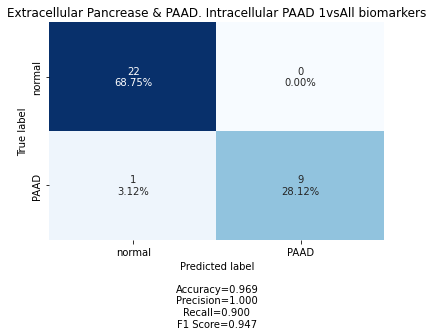

In [21]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# categories = ['Zero', 'One']
categories = ["normal", "PAAD"]
title =  "Extracellular Pancrease & PAAD. Intracellular PAAD 1vsAll biomarkers"
fig, panel = make_confusion_matrix(confusion_matrix, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [22]:
imgFilePL = imgOutPl.joinpath(NOTEBOOK_NAME + "-ConfusionMatrix.png")
print(imgFilePL)
fig.savefig(imgFilePL, dpi=600,  bbox_inches='tight', facecolor="white", transparent=True )

img/testIntraCellularBiomarkersOnExtracellularSamples/testIntraCellularBiomarkersOnExtracellularSamples-ConfusionMatrix.png
